# Navigation with Hill-Climbing


---

Solving Navigation Project with Hill-Climbing

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env.brain_names

['BananaBrain']

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's MY Turn!

In [6]:
import gym

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns

In [7]:
class Policy():
    def __init__(self, s_size=37, a_size=4):
        self.w = 1e-4*np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probs = self.forward(state)
        #action = np.random.choice(2, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

In [8]:
policy = Policy()

In [9]:
def hill_climbing(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, noise_scale=1e-2):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    for i_episode in range(1, n_episodes+1):
        rewards = []
        env_info = env.reset(train_mode=True)[brain_name]
        state = state = env_info.vector_observations[0]
        for t in range(max_t):
            action = policy.act(state)
            env_info = env.step(action)[brain_name]
            state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        if R >= best_R: # found better weights
            best_R = R
            best_w = policy.w
            noise_scale = max(1e-4, noise_scale / 2)
            policy.w += noise_scale * np.random.rand(*policy.w.shape) 
        else: # did not find better weights
            noise_scale = min(2, noise_scale * 2)
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=15:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            policy.w = best_w
            break
        
    return scores

In [10]:
scores = hill_climbing()

Episode 100	Average Score: 0.00
Episode 200	Average Score: -0.29
Episode 300	Average Score: -0.27
Episode 400	Average Score: -0.52
Episode 500	Average Score: -0.30
Episode 600	Average Score: -0.66
Episode 700	Average Score: -0.93
Episode 800	Average Score: -1.33
Episode 900	Average Score: -1.28
Episode 1000	Average Score: -1.17


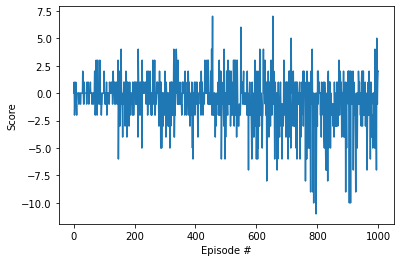

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
import pickle

with open('saved_scores/hill_climbing/scores_hill_climbing_4.pkl', 'wb') as f:
  pickle.dump(scores, f)

In [14]:
env.close()